## Set Up

In [2]:
import pandas as pd

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import *

from pyspark.sql import SparkSession
from pyspark.sql.functions import col, countDistinct, udf
from pyspark.sql.types import ArrayType, IntegerType,  StringType

spark = SparkSession.builder.getOrCreate()

## Pull in Data

In [3]:
full_path = '/project/ds5559/r-slash-group8/sample.csv'

df = spark.read.csv(full_path,  inferSchema=True, header = True)

In [4]:
# convert integer cols (ups, downs, and gilded) to integers
# Note: we could have done this by defining a schema before the csv read
df=df.withColumn("ups",df.ups.cast(IntegerType()))
df=df.withColumn("downs",df.downs.cast(IntegerType()))
df=df.withColumn("gilded",df.gilded.cast(IntegerType()))

# Confirm new schema
df.printSchema()
df.show(5)

root
 |-- _c0: string (nullable = true)
 |-- created_utc: string (nullable = true)
 |-- ups: integer (nullable = true)
 |-- subreddit_id: string (nullable = true)
 |-- link_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- score_hidden: string (nullable = true)
 |-- author_flair_css_class: string (nullable = true)
 |-- author_flair_text: string (nullable = true)
 |-- subreddit: string (nullable = true)
 |-- id: string (nullable = true)
 |-- removal_reason: string (nullable = true)
 |-- gilded: integer (nullable = true)
 |-- downs: integer (nullable = true)
 |-- archived: string (nullable = true)
 |-- author: string (nullable = true)
 |-- score: string (nullable = true)
 |-- retrieved_on: string (nullable = true)
 |-- body: string (nullable = true)
 |-- distinguished: string (nullable = true)
 |-- edited: string (nullable = true)
 |-- controversiality: string (nullable = true)
 |-- parent_id: string (nullable = true)

+--------------------------------+-----------+---

In [5]:
df.count()

15317725

In [6]:
# Remove null in important columns
print(df.filter(df['body'].isNull()).count())
print(df.filter(df['subreddit_id'].isNull()).count())

df=df.filter(df['body'].isNotNull())
df=df.filter(df['subreddit_id'].isNotNull())

df.count()

5315303
2969558


10002410

In [7]:
# some rows have the body in the subreddit column, I'll remove these
print(df.filter(df['subreddit'].rlike('\s')).count())

df = df.filter(df['subreddit'].rlike('^[A-Za-z1-9_]+$'))
df.count() #filter out spaces and special characters except for underscores

5491


9950519

In [8]:
# how many subredits are there?
df.select('subreddit_id').distinct().count()

26882

In [9]:
# get highest volume subreddits
top_sr = df.groupby('subreddit_id').agg({'subreddit_id':'count'}).sort(col('count(subreddit_id)').desc())
top_sr.show(5)

+------------+-------------------+
|subreddit_id|count(subreddit_id)|
+------------+-------------------+
|    t5_2qh1i|             756074|
|    t5_2rfxx|             194454|
|    t5_2qh0u|             142840|
|    t5_2qmg3|             138655|
|    t5_2qh33|             137526|
+------------+-------------------+
only showing top 5 rows



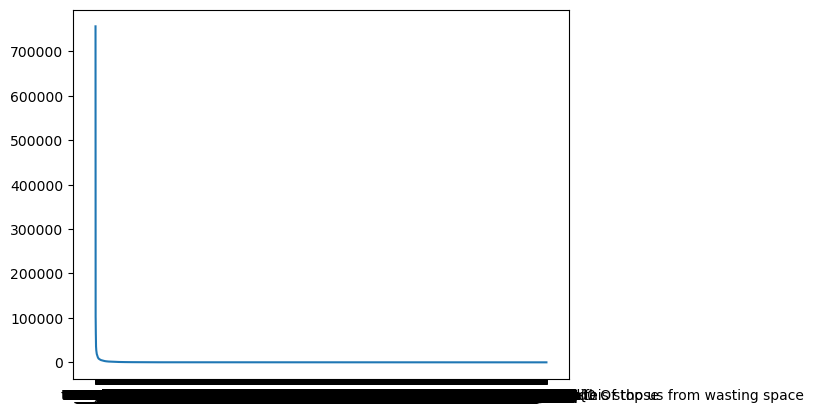

In [17]:
import matplotlib.pyplot as plt
pd_df = top_sr.toPandas()
plt.plot(pd_df['subreddit_id'],pd_df['count(subreddit_id)'])
plt.show()

In [18]:
import matplotlib.pyplot as plt
pd_df = top_sr.toPandas()
pd_df2 = pd_df.iloc(:500)
plt.plot(pd_df2['subreddit_id'],pd_df2['count(subreddit_id)'])
plt.show()

SyntaxError: invalid syntax (<ipython-input-18-ef9f84c7075e>, line 3)

In [11]:
# 1000 seems like a good cut off point.  Subreddits have 1000+ comments
top_sr.limit(250).tail(1)

[Row(subreddit_id='t5_2rfz5', count(subreddit_id)=6565)]

In [11]:
# add names based on frist appearance
# top_sr = top_sr.withColumn('subreddit',df.filter(df['subreddit_id']==top_sr['subreddit_id']))
top_sr = top_sr.join(df.select('subreddit','subreddit_id').dropDuplicates(['subreddit']),on='subreddit_id', how='inner').sort(col('count(subreddit_id)').desc())
top_sr


# NOTE: It looks like some of the data still has issues because I still have duplicates probably meaning there are some rows that have comment text in the subreddit column.  
#They weren't eliminated because the comments happen to follow subreddit naming conventions.  More work would be helpful here.
# My goal is to elminate unpopular subreddits so we have fewer categories to work with.  Not sure how important working with names really is.

DataFrame[subreddit_id: string, count(subreddit_id): bigint, subreddit: string]

In [12]:
# top 1000 subreddits
top_sr2 = top_sr.limit(1000)
top_sr2.show(5)

+------------+-------------------+---------------+
|subreddit_id|count(subreddit_id)|      subreddit|
+------------+-------------------+---------------+
|    t5_2qh1i|             756074|      AskReddit|
|    t5_2rfxx|             194454|leagueoflegends|
|    t5_2qh0u|             142840|           pics|
|    t5_2qmg3|             138655|            nfl|
|    t5_2qh33|             137526|          funny|
+------------+-------------------+---------------+
only showing top 5 rows



In [23]:
# eliminate data from lower level records

df_topSr = df.join(top_sr2.select('subreddit_id'), on = 'subreddit_id')

In [24]:
df_topSr.columns

['subreddit_id',
 '_c0',
 'created_utc',
 'ups',
 'link_id',
 'name',
 'score_hidden',
 'author_flair_css_class',
 'author_flair_text',
 'subreddit',
 'id',
 'removal_reason',
 'gilded',
 'downs',
 'archived',
 'author',
 'score',
 'retrieved_on',
 'body',
 'distinguished',
 'edited',
 'controversiality',
 'parent_id']

In [25]:
df_topSr.count()

8799960

In [26]:
df_topSr.show(10)

+------------+---+-----------+---+---------+----------+------------+----------------------+-----------------+---------------+-------+--------------+------+-----+--------+---------------+-----+------------+--------------------+-------------+------+----------------+----------+
|subreddit_id|_c0|created_utc|ups|  link_id|      name|score_hidden|author_flair_css_class|author_flair_text|      subreddit|     id|removal_reason|gilded|downs|archived|         author|score|retrieved_on|                body|distinguished|edited|controversiality| parent_id|
+------------+---+-----------+---+---------+----------+------------+----------------------+-----------------+---------------+-------+--------------+------+-----+--------+---------------+-----+------------+--------------------+-------------+------+----------------+----------+
|    t5_2qo4s|  2| 1430438400|  4|t3_34g8mx|t1_cqug90h|           0|                  Heat|             Heat|            nba|cqug90h|            NA|     0|    0|       0|  

In [29]:
df_topSr.write.csv('jordan_subset', header=True)